### Введение

**Суть проекта**

Компания онлайн-сервис с высоким уровнем входящего трафика имеет специализированный отдел безопасности, который занимается фильтрацией и анализом трафика. Сотрудники этого отдела обратились за помощью в автоматизации выявления аномального и злонамеренного трафика.


**Задача верхнеуровнево**

Разработем модель, которая будет классифицировать трафик на нормальный и злонамеренный, включая следующие типы атак: DDoS, SQL-инъекции, брутфорс, вредоносные программы и т.д.

**Технически**

Модель должна работать максимально качественно, так как цена ошибки может быть очень высока.\
Оценим качество модели по различным метрикам классификации: precision, recall, f1_score.

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
import catboost

In [2]:
df = pd.read_csv('F:\\Развитие\\DS\\Хакатоны\\Злонамеренный трафик 10.23\\Network_traffic_data.csv')

### 1. Exploratory Data Analisys

In [3]:
#Размер датасета
df.shape

(539616, 79)

In [4]:
#Какие фичи имеем
df.columns

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

In [5]:
#Уберем лишние пробелы в названии фичей
df.columns = df.columns.str.replace(' ', '')

Оириентируясь на названия, можно сказать, что датасет имеет одну категориальную фичу - DestinationPort.

In [6]:
#Посмотрим на датасет
pd.options.display.max_columns = None
display(df.head(10))

,DestinationPort,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthMean,FwdPacketLengthStd,BwdPacketLengthMax,BwdPacketLengthMin,BwdPacketLengthMean,BwdPacketLengthStd,FlowBytes/s,FlowPackets/s,FlowIATMean,FlowIATStd,FlowIATMax,FlowIATMin,FwdIATTotal,FwdIATMean,FwdIATStd,FwdIATMax,FwdIATMin,BwdIATTotal,BwdIATMean,BwdIATStd,BwdIATMax,BwdIATMin,FwdPSHFlags,BwdPSHFlags,FwdURGFlags,BwdURGFlags,FwdHeaderLength,BwdHeaderLength,FwdPackets/s,BwdPackets/s,MinPacketLength,MaxPacketLength,PacketLengthMean,PacketLengthStd,PacketLengthVariance,FINFlagCount,SYNFlagCount,RSTFlagCount,PSHFlagCount,ACKFlagCount,URGFlagCount,CWEFlagCount,ECEFlagCount,Down/UpRatio,AveragePacketSize,AvgFwdSegmentSize,AvgBwdSegmentSize,FwdHeaderLength.1,FwdAvgBytes/Bulk,FwdAvgPackets/Bulk,FwdAvgBulkRate,BwdAvgBytes/Bulk,BwdAvgPackets/Bulk,BwdAvgBulkRate,SubflowFwdPackets,SubflowFwdBytes,SubflowBwdPackets,SubflowBwdBytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin,Label
0,80,5480074,3,1,12,0,6,0,4.000,3.465,0,0,0.0,0.0,2.189751,0.729917,1.826691e+06,3.131700e+06,5442804,101,5480074,2740037.000,3.822290e+06,5442804,37270,0,0.000,0.00,0,0,0,0,0,0,72,32,0.547438,0.182479,0,6,2.40,3.287,10.80000,0,0,0,1,0,0,0,0,0,3.00,4.000,0.0,72,0,0,0,0,0,0,3,12,1,0,8192,42780,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,443,711977,9,10,703,3950,267,0,78.100,103.300,1448,0,395.0,587.5,6535.323473,26.686255,3.955428e+04,5.015462e+04,120501,1,616301,77037.625,7.299598e+04,215614,230,616874,68541.555,71985.97,199836,1,0,0,0,0,296,328,12.640858,14.045398,0,1448,232.60,442.800,196012.66000,0,0,0,1,0,0,0,0,1,244.90,78.100,395.0,296,0,0,0,0,0,0,9,703,10,3950,29200,252,4,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,53,153398,2,2,80,224,40,40,40.000,0.000,112,112,112.0,0.0,1981.772904,26.075959,5.113267e+04,8.855831e+04,153391,3,3,3.000,0.000000e+00,3,3,4,4.000,0.00,4,4,0,0,0,0,40,40,13.037980,13.037980,40,112,68.80,39.440,1555.20000,0,0,0,0,0,0,0,0,1,86.00,40.000,112.0,40,0,0,0,0,0,0,2,80,2,224,-1,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,53,57660,1,1,46,128,46,46,46.000,0.000,128,128,128.0,0.0,3017.689906,34.686091,5.766000e+04,0.000000e+00,57660,57660,0,0.000,0.000000e+00,0,0,0,0.000,0.00,0,0,0,0,0,0,20,20,17.343046,17.343046,46,128,73.30,47.340,2241.33330,0,0,0,0,0,0,0,0,1,110.00,46.000,128.0,20,0,0,0,0,0,0,1,46,1,128,-1,-1,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,8446,767,3,1,43,6,31,6,14.336,14.440,6,6,6.0,0.0,63885.267280,5215.123859,2.556667e+02,3.942896e+02,710,3,713,356.500,4.999245e+02,710,3,0,0.000,0.00,0,0,0,0,0,0,60,20,3911.342800,1303.781000,6,31,11.00,11.180,125.00000,0,0,0,0,1,0,0,0,0,13.75,14.336,6.0,60,0,0,0,0,0,0,3,43,1,6,1017,0,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
5,47210,3,2,0,0,0,0,0,0.000,0.000,0,0,0.0,0.0,0.000000,666666.666700,3.000000e+00,0.000000e+00,3,3,3,3.000,0.000000e+00,3,3,0,0.000,0.00,0,0,0,0,0,0,64,0,666666.700000,0.000000,0,0,0.00,0.000,0.00000,0,0,0,0,1,0,0,0,0,0.00,0.000,0.0,64,0,0,0,0,0,0,2,0,0,0,361,-1,0,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
6,53,111373,4,2,168,116,42,42,42.000,0.000,58,58,58.0,0.0,2549.989674,53.873021,2.227460e+04,3.493425e+04,79780,3,31590,10530.000,1.823330e+04,31584,3,3,3.000,0.00,3,3,0,0,0,0,104,64,35.915348,17.957674,42,58,46.56,7.810,60.95238,0,0,0,0,0,0,0,0,0,54.34,42.000,58.0,104,0,0,0,0,0,0,4,168,2,116,-1,-1,3,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
7,443,65786373,122,191,23544,275883,1093,0,193.000,366.200,4380,0,1444.0,689.0,4551.504914,4.757824,2.108538e+05,2.919396e+06,51185854,1,65786373,543689.060,4.680394e+06,51185854,1,14585289,76764.680,484025.84,4827482,1,0,0,0,0,2464,3832,1.854487,2.903337,0,4380,953.50,846.000,715368.30000,0,0,0,1,0,0,0,0,1,956.50,193.000,1444.0,2464,0,0,0,0,0,0,122,23544,191,275883,65535,75,121,20,14600467.0,0.0,14600467,14600467,51185856.0,0.0,51185854,51185854,BENIGN
8,1877,213,3,1,43,6,31,6,14.336,14.440,6,6,6.

In [7]:
#Посмотрим на характеристики распределения фичей
pd.options.display.max_columns = None
display(df.describe())

,DestinationPort,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthMean,FwdPacketLengthStd,BwdPacketLengthMax,BwdPacketLengthMin,BwdPacketLengthMean,BwdPacketLengthStd,FlowBytes/s,FlowPackets/s,FlowIATMean,FlowIATStd,FlowIATMax,FlowIATMin,FwdIATTotal,FwdIATMean,FwdIATStd,FwdIATMax,FwdIATMin,BwdIATTotal,BwdIATMean,BwdIATStd,BwdIATMax,BwdIATMin,FwdPSHFlags,BwdPSHFlags,FwdURGFlags,BwdURGFlags,FwdHeaderLength,BwdHeaderLength,FwdPackets/s,BwdPackets/s,MinPacketLength,MaxPacketLength,PacketLengthMean,PacketLengthStd,PacketLengthVariance,FINFlagCount,SYNFlagCount,RSTFlagCount,PSHFlagCount,ACKFlagCount,URGFlagCount,CWEFlagCount,ECEFlagCount,Down/UpRatio,AveragePacketSize,AvgFwdSegmentSize,AvgBwdSegmentSize,FwdHeaderLength.1,FwdAvgBytes/Bulk,FwdAvgPackets/Bulk,FwdAvgBulkRate,BwdAvgBytes/Bulk,BwdAvgPackets/Bulk,BwdAvgBulkRate,SubflowFwdPackets,SubflowFwdBytes,SubflowBwdPackets,SubflowBwdBytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin
count,539616.000000,5.396160e+05,539616.000000,539616.000000,5.396160e+05,5.396160e+05,539616.000000,539616.000000,539616.000000,539616.000000,539616.000000,539616.000000,539616.000000,539616.000000,5.391280e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,539616.000000,539616.0,539616.000000,539616.0,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,539616.000000,539616.000000,539616.000000,539616.000000,5.396160e+05,539616.000000,539616.000000,539616.000000,539616.000000,539616.000000,539616.000000,539616.000000,539616.000000,539616.000000,539616.000000,539616.000000,539616.000000,5.396160e+05,539616.0,539616.0,539616.0,539616.0,539616.0,539616.0,539616.000000,5.396160e+05,539616.000000,5.396160e+05,539616.000000,539616.000000,539616.000000,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05,5.396160e+05
mean,5563.061394,2.106693e+07,6.119972,5.985495,4.082371e+02,7.999779e+03,169.449966,11.855382,44.681011,59.525095,1675.074384,23.508936,550.037006,697.306414,inf,inf,2.134902e+06,5.264535e+06,1.731840e+07,2.945584e+05,2.075634e+07,4.036797e+06,6.666492e+06,1.720041e+07,1.035760e+06,9.601754e+06,2.028745e+06,2.413091e+06,6.464188e+06,8.147788e+05,0.036747,0.0,0.000056,0.0,-4.593957e+03,-4.290450e+03,7.142149e+04,7.885307e+03,9.609552,1723.695630,276.581177,544.090932,1.112688e+06,0.062524,0.036747,0.000120,0.377765,0.365884,0.060567,0.000056,0.000120,0.643446,305.358765,44.681011,550.037006,-4.593957e+03,0.0,0.0,0.0,0.0,0.0,0.0,6.119972,4.082371e+02,5.985495,7.998768e+03,7564.762311,1277.937053,2.946516,-2.429314e+03,1.154984e+05,4.037570e+04,1.672882e+05,8.983017e+04,1.610155e+07,9.585649e+05,1.687227e+07,1.539150e+07
std,14921.262751,3.812172e+07,345.109317,463.490949,7.478351e+03,1.014442e+06,560.533869,60.961661,150.873880,217.729412,2843.534429,55.198582,869.702147,1255.312166,NaN,NaN,5.824585e+06,1.055110e+07,3.395701e+07,4.269410e+06,3.812106e+07,1.062759e+07,1.391409e+07,3.402154e+07,8.949951e+06,2.807218e+07,9.045625e+06,8.975673e+06,2.192197e+07,7.698887e+06,0.188139,0.0,0.007456,0.0,2.095355e+06,2.076610e+06,2.685287e+05,3.847268e+04,21.551058,2862.902929,416.169617,903.656284,2.468134e+06,0.242105,0.188139,0.010975,0.484829,0.481678,0.238535,0.007456,0.010975,0.634460,457.152955,150.873880,869.702147,2.095355e+06,0.0,0.0,0.0,0.0,0.0,0.0,345.109317,7.478351e+03,463.490949,1.013814e+06,13440.653528,6590.247532,267.510434,1.052329e+06,7.787530e+05,4.347032e+05,1.059626e+06,7.099710e+05,3.315463e+07,6.461275e+06,3.403851e+07,3.295695e+07
min,0.000000,-1.200000e+01,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.20

Видим:
- бесполезные столбцы с полностью нулевыми значениями
- признаки с бесконечно-большими значениями (inf)
- большой разброс в средних значениях признаков (будет полезно провести масштабирование)

In [8]:
#Удалим фичи с полностью нулевыми значениями
df.drop(['FwdAvgBytes/Bulk', 'FwdAvgPackets/Bulk',
       'FwdAvgBulkRate', 'BwdAvgBytes/Bulk', 'BwdAvgPackets/Bulk',
       'BwdAvgBulkRate', 'BwdPSHFlags',  'FwdURGFlags', 'BwdURGFlags'], axis = 1, inplace = True)

In [9]:
#Заменим бесконечно большие значения на максимальное значения этого признака
m1 = df.loc[df['FlowBytes/s'] != np.inf, 'FlowBytes/s'].max()
df['FlowBytes/s'].replace(np.inf, m1, inplace=True)
m2 =  df.loc[df['FlowPackets/s'] != np.inf, 'FlowPackets/s'].max()
df['FlowPackets/s'].replace(np.inf, m2, inplace=True)

In [10]:
#Посмотрим на пропуски и типы данных у фичей
total = df.isnull().sum()
percent = ((df.isnull().sum()/df.isnull().count())*100).round(2)
missing = pd.concat([total, percent], axis = 1, keys = ['Total_missing_values', 'Percent%'])
missing['dtype'] = df.dtypes
pd.options.display.max_rows = None
display(missing)

,Total_missing_values,Percent%,dtype
DestinationPort,0,0.00,int64
FlowDuration,0,0.00,int64
TotalFwdPackets,0,0.00,int64
TotalBackwardPackets,0,0.00,int64
TotalLengthofFwdPackets,0,0.00,int64
TotalLengthofBwdPackets,0,0.00,int64
FwdPacketLengthMax,0,0.00,int64
FwdPacketLengthMin,0,0.00,int64
FwdPacketLengthMean,0,0.00,float64
FwdPacketLengthStd,0,0.00,float64


<Axes: >

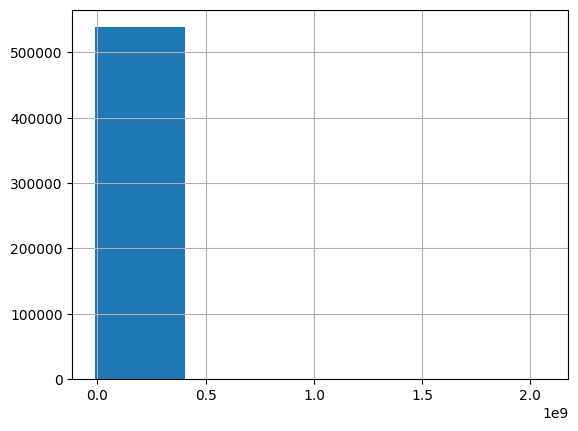

In [11]:
#Посмотрим на распределение признака с пропусками
df['FlowBytes/s'].hist(bins = 5)

Видим, что основная масса значений лежит в промежутке от 0 до 0,4. Заменим пропущенные значения на 0,2 (среднее среднего).

In [12]:
df['FlowBytes/s'] = df['FlowBytes/s'].fillna(value = 0.2)

In [13]:
df.shape

(539616, 70)

In [14]:
#Закодируем названия фичей, чтобы дальше было проще ориентроваться
lst = []
for i in range(70):
    lst.append(i)
df.columns = lst

In [15]:
#Проверим, нет ли в данных мультиколлинеарных признаков
df_c = df.corr()
x = []
for i in df_c.columns:
    st = pd.DataFrame(df_c[df_c[i] > 0.98][i])
    x.append(st)
y = pd.concat(x)
y

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68
0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,NaN,0.999212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,0.999204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,0.998667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,NaN,NaN,0.999204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56,NaN,NaN,0.998668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,0.999204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Так как качестве модели будем использовать катбуст, удалим один из связанных признаков. Так как корреляция влияет на разбиение при построении деревьев решений. Связанными признаками будем считать те, у которых корреляция больше 0,98.

In [16]:
df = df.drop([1, 2, 4, 5, 8, 10, 12, 18, 23, 30, 31, 32, 36, 37, 42, 68], axis = 1)
df = df.drop_duplicates().reset_index(drop = True)

In [17]:
#Разобьем данные на обучающую и тестовую выборки
features_train, features_valid, target_train, target_valid = train_test_split(df.drop(69, axis = 1),
                                df[69], test_size=0.35, random_state = 123, stratify = df[69])

In [18]:
#Масштабируем численные признаки
categoric_train = features_train[0]
numeric_train = features_train.drop([0], axis = 1)
categoric_valid = features_valid[0]
numeric_valid = features_valid.drop([0], axis = 1)
scaler = StandardScaler()
scaler.fit(numeric_train)
features_train_scaled = pd.DataFrame(scaler.transform(numeric_train), columns = numeric_train.columns,
                                     index = numeric_train.index.tolist()) 
features_valid_scaled = pd.DataFrame(scaler.transform(numeric_valid), columns = numeric_valid.columns,
                                    index = numeric_valid.index.tolist())
features_train = pd.concat([categoric_train, features_train_scaled], axis=1)
features_valid = pd.concat([categoric_valid, features_valid_scaled], axis=1)

### 2. Разработаем модель

In [19]:
#Обучим модель
model_cat = CatBoostClassifier(cat_features = [0], iterations = 991, learning_rate = 0.1, random_seed=43)
model_cat.fit(features_train, target_train, verbose=100, plot = True, eval_set = (features_valid, target_valid ))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.5692156	test: 1.5696588	best: 1.5696588 (0)	total: 2.15s	remaining: 35m 30s
100:	learn: 0.0194199	test: 0.0200022	best: 0.0200022 (100)	total: 3m 30s	remaining: 30m 50s
200:	learn: 0.0111973	test: 0.0119107	best: 0.0119107 (200)	total: 7m 30s	remaining: 29m 32s
300:	learn: 0.0090370	test: 0.0099552	best: 0.0099552 (300)	total: 11m 3s	remaining: 25m 21s
400:	learn: 0.0080371	test: 0.0091576	best: 0.0091576 (400)	total: 14m 40s	remaining: 21m 35s
500:	learn: 0.0074575	test: 0.0088207	best: 0.0088185 (497)	total: 18m 31s	remaining: 18m 7s
600:	learn: 0.0070019	test: 0.0085251	best: 0.0085238 (599)	total: 22m 27s	remaining: 14m 34s
700:	learn: 0.0066406	test: 0.0083164	best: 0.0083164 (700)	total: 26m 18s	remaining: 10m 52s
800:	learn: 0.0063489	test: 0.0081771	best: 0.0081771 (800)	total: 29m 43s	remaining: 7m 3s
900:	learn: 0.0061047	test: 0.0080698	best: 0.0080696 (893)	total: 33m 11s	remaining: 3m 18s
990:	learn: 0.0059191	test: 0.0080081	best: 0.0080081 (990)	total: 36m 18

In [20]:
#Сделаем предсказание
predictions_cat = model_cat.predict(features_valid)

In [21]:
report = classification_report(target_valid, predictions_cat) 
print(report)

                            precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00     81447
                       Bot       0.95      0.97      0.96       684
                      DDoS       1.00      1.00      1.00     22527
             DoS GoldenEye       1.00      0.99      1.00      3599
                  DoS Hulk       1.00      1.00      1.00     30538
          DoS Slowhttptest       1.00      0.99      0.99      1830
             DoS slowloris       1.00      0.99      1.00      1885
               FTP-Patator       1.00      1.00      1.00      2077
                Heartbleed       1.00      1.00      1.00         4
              Infiltration       1.00      0.69      0.82        13
                  PortScan       1.00      1.00      1.00     19739
               SSH-Patator       1.00      1.00      1.00      1127
  Web Attack � Brute Force       0.73      0.86      0.79       514
Web Attack � Sql Injection       1.00      0.57

### Итог

Итак, мы построили модель, которая по ряду фичей предсказывает вид злонамеренного трафика. И делает это достаточно точно.